# Quantum Polar Decoding on Amazon Braket
This file demonstrates the algorithm explained in our paper **"Quantum Channel Decoding"** as submitted to the [QEC-22 conference](https://qce.quantum.ieee.org/2022/).

Please refer to the readme file in this folder for more information about setting up the environment, installing the required packages, and getting ready to run this notebook with Amazon Braket.

Copyright &copy; 2022 InterDigital AI Research Lab

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from quantumpolardecoder import QuantumPolar
from polarsc import scDecode, sclDecode
QuantumPolar.setPlatform("BRAKET")   # By default this is set to QISKIT if both packages are installed

Software platform changed to 'BRAKET'.


You can unremark the other devices to run on Braket's simulators or real quantum computers. Before selecting a device, in Amazon Braket, go to ``Devices`` and make sure it is currently available. Also please note that even if the device is available, it will probably run slower than your local device simulation. So, please be patient.

In [2]:
from braket.aws import AwsDevice
from braket.devices import LocalSimulator

device = LocalSimulator()
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
# device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1")
# device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
# device = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")

## Creating a QuantumPolar class
Here we first create a ``QuantumPolar`` class for (16,8) Polar Decoding, which means we are using 8-bit messages embedded in 16-bit code-words. The ``getRandomMessage`` method creates a random message and returns it together with the corresponding code-word, BPSK-modulated signal, and noisy received signal. 

Then we print the message information before calling a series of decoding functions to decode the noisy received signal using **Successive Cancellation**, **Successive Cancellation List**, and **Quantum** algorithms.

In [3]:
# Instantiate a QuantumPolar class
qp = QuantumPolar(16, 8, device=device)

ebNoDb = 4
# Create a random message (msg), and the corresponding codeWord, BPSK transmitted signal, noisy
# received signal "rx", and the noise power based on the given Eb/N0 value.
msg, msgCrc, u, codeWord, tx, rx, sigma2 = qp.getRandomMessage(ebNoDb)
print("Message:       ", "  ".join("%4d"%(x) for x in msg))
if qp.nCrc>0:
    print("Message+CRC:   ", "  ".join("%4d"%(x) for x in msgCrc))    
print("u:             ", "  ".join("%4d"%(x) for x in u))
print("codeWord:      ", "  ".join("%4d"%(x) for x in codeWord))
print("Noisy Rx:      ", "  ".join("%4.1f"%(x) for x in rx))
cwHat = np.int8(rx<0)
print("Hard-Decision: ","  ".join("%4d"%(x) for x in cwHat))
print("Num bit errors:", sum((cwh!=cw) for cwh, cw in zip(cwHat,codeWord)), "(Hard Decision)")
uHat = cwHat.dot(qp.g)%2
print("Num bit errors:", sum(uh!=uu for uh,uu in zip(uHat,u)), "(u)")

print("\nDecoding with different algorithms:")
print("  Org. Message:                 ", "  ".join("%1d"%(x) for x in msg))

msgHat = qp.testSc(msg, rx-tx)
print("  Decoded Message(SC):          ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

l=4
msgHat = qp.decodeScl(rx, l)        
print("  Decoded Message(SCL-%d):       "%l, "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

msgHat = qp.decodeFast(rx)
print("  Decoded Message(Quantum-Fast):", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

msgHat = qp.decode(rx)
print("  Decoded Message(Quantum):     ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")


Message:           0     0     0     0     1     1     0     0
u:                 0     0     0     0     0     0     0     0     0     0     0     1     0     1     0     0
codeWord:          0     0     1     1     1     1     0     0     0     0     1     1     1     1     0     0
Noisy Rx:        0.1   0.7  -1.8  -0.8  -0.2  -0.7   0.5   0.3   1.4  -0.6  -0.5  -0.2  -0.7  -1.1   1.2   1.6
Hard-Decision:     0     0     1     1     1     1     0     0     0     1     1     1     1     1     0     0
Num bit errors: 1 (Hard Decision)
Num bit errors: 4 (u)

Decoding with different algorithms:
  Org. Message:                  0  0  0  0  1  1  0  0
  Decoded Message(SC):           0  0  0  0  1  1  0  0 ✓
  Decoded Message(SCL-4):        0  0  0  0  1  1  0  0 ✓
  Decoded Message(Quantum-Fast): 0  0  0  0  1  1  0  0 ✓
  Decoded Message(Quantum):      0  0  0  0  1  1  0  0 ✓


## The quantum results statistics after executing the circuit
Now we print the bitstreams with highest "counts" and draw a histogram based on the counts. The correlation between the noisy received signal and each code-word is shown in the last column of the table.


Top-10 Candidates:
    Qubits    Count  U-FFFFFFMMFFMMMMMM  MSG       Code-Word         Corr.
    00010100  409      0000000000010100  00001100  0011110000111100  11.105  ✓
    00100100  140      0000000000100100  01000100  0110110001101100  8.855   
    11010100  117      0000001100010100  10011100  0110100100111100  6.223   
    10010100  69       0000001000010100  10001100  1001011000111100  5.924   
    00110100  54       0000000000110100  01001100  1001110010011100  3.643   
    11100100  38       0000001100100100  11010100  0011100101101100  9.724   
    00011100  31       0000000000011100  00101100  1011010010110100  6.452   
    10100100  24       0000001000100100  11000100  1100011001101100  3.674   
    00000100  23       0000000000000100  00000100  1100110011001100  1.393   
    01010100  22       0000000100010100  00011100  1100001100111100  1.042   


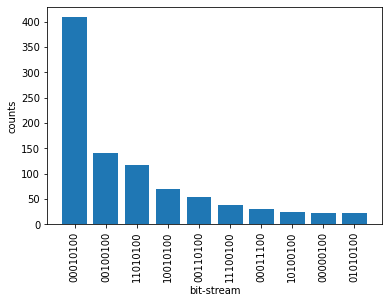

In [4]:
# Get up to 10 bitstreams with highest counts
qp.printStats(rx, msgHat, msg, k=10, histogram=True)


## Showing the Quantum Polar Decoder circuit
Now we can print the circuit and its depth.

In [5]:
print("Circuit Depth:", qp.circuit.depth)
print(qp.circuit)

Circuit Depth: 5
T  : |   0    |1| 2 | 3 | 4 |
                             
q0 : -Ry(0.73)-X---------X---
               |         |   
q1 : -Ry(1.01)-C---------|-X-
                         | | 
q2 : -Ry(2.42)-X-----X---|-|-
               |     |   | | 
q3 : -Ry(2.04)-C-----|-X-|-|-
                     | | | | 
q4 : -Ry(2.62)-X-X---|-|-|-|-
               | |   | | | | 
q5 : -Ry(2.90)-C-|-X-|-|-|-|-
                 | | | | | | 
q6 : -Ry(0.16)-X-C-|-C-|-C-|-
               |   |   |   | 
q7 : -Ry(0.09)-C---C---C---C-

T  : |   0    |1| 2 | 3 | 4 |
